# pset 08: the adventure of the chimeric reads 
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt     
import scipy.special as special     
from scipy.special import logsumexp

%matplotlib inline


For this week, we have 200bp reads that are chimeric mixtures of two phages: T4 and AluminumJesus. Each read has exactly one breakpoint where it switches from one phage to the other and we can identify the source by GC content (AluminumJesus is about 67% GC and T4 is about 35% GC). There are 3 states in our HMM structure: 

State 0: Start/end state (doesn't emit)

State 1: AluminumJesus state (high GC)

State 2: T4 state (low GC)

In [3]:
def make_hmm():
     p = 1/200   # Mean seg length of 100. 

     t = np.array([[ 0.0, 1/2,   1/2 ],     # state 0 = start/end
                   [ p, 1-2*p,     p ],     # state 1 = AluminumJesus
                   [ p,     p, 1-2*p ]] )   # state 2 = T4

     e = np.array([[   1/4,   1/4,   1/4,   1/4 ],    # unused; start/end state doesn't emit
                   [ 0.166, 0.334, 0.334, 0.166 ],    # AluminumJesus residue composition
                   [ 0.323, 0.177, 0.177, 0.323 ]] )  # T4 residue composition
     return (t,e)

## 1. Implement the standard HMM algorithms 

### 1.1 Viterbi: Find most likely state path π

In [5]:
def viterbi(x, t, e):
    """
    Parameters:
        x: List of indices for observed sequence (0-based indices for A,C,G,T)
        t: (M+1)x(M+1) transition probability matrix
        e: (M+1)x4 emission probability matrix
    
    Returns:
        path: Optimal state path
        log_prob: Log probability of optimal path P(x,π|θ)
    """
    L = len(x)  # sequence length
    M = len(t) - 1  # number of states (excluding state 0)
    
    # initialization
    # V[0,k] = -infinity for all k > 0
    V = np.full((L+1, M+1), -np.inf)  # log probabilities
    V[0, 0] = 0
    ptr = np.zeros((L+ 1, M + 1), dtype=int)  # traceback pointers
    
    eps = np.finfo(float).tiny # add small epsilon to avoid log(0)
    log_t = np.log(t + eps)
    log_e = np.log(e + eps)

    # recursion
    for i in range(1, L + 1):
        for k in range(1, M + 1):
            log_emit = log_e[k, x[i-1]]
            scores = V[i-1, :] + log_t[:, k]
            best_j = np.argmax(scores)
            V[i, k] = log_emit + scores[best_j]
            ptr[i, k] = best_j
    
    # termination
    final_scores = V[L, :] + log_t[:, 0]
    log_prob = np.max(final_scores)
    path = np.zeros(L + 1, dtype=int)
    path[L] = np.argmax(final_scores)
    
    # traceback
    for i in range(L, 0, -1):
        path[i-1] = ptr[i, path[i]]
    
    return path[1:], log_prob


### 1.2 Forward: Calculate P(x|θ) by summing over all paths

In [7]:
def forward(x, t, e):
    """
    Parameters:
        x: List of indices for observed sequence (0-based indices for A,C,G,T)
        t: (M+1)x(M+1) transition probability matrix
        e: (M+1)x4 emission probability matrix
    
    Returns:
        F: Forward matrix of log probabilities
        log_px: Log probability of sequence P(x|θ)
    """
    L = len(x) 
    M = len(t) - 1  
    
    # initialization
    # F[0,k] = -infinity for all k > 0 is handled by np.full
    F = np.full((L + 1, M + 1), -np.inf)  # log probabilities
    F[0, 0] = 0

    eps = np.finfo(float).tiny
    log_t = np.log(t + eps)
    log_e = np.log(e + eps)

    # recursion
    for i in range(1, L+1):
        for k in range(1, M+1):
            log_emit = log_e[k, x[i-1]]
            terms = F[i-1, :] + log_t[:, k]
            F[i, k] = logsumexp(terms) + log_emit
    
    # termination
    final_terms = F[L, :] + log_t[:, 0]
    log_px = logsumexp(final_terms)
    
    return F, log_px

    

### 1.3 Backward: Calculate P(x|θ) working backwards

In [9]:
def backward(x, t, e):
    """
    Parameters:
        x: List of indices for observed sequence (0-based indices for A,C,G,T)
        t: (M+1)x(M+1) transition probability matrix
        e: (M+1)x4 emission probability matrix
    
    Returns:
        B: Backward matrix of log probabilities
        log_px: Log probability of sequence P(x|θ)
    """
    L = len(x) 
    M = len(t) - 1  
    
    # initialize Backward matrix
    B = np.full((L + 1, M + 1), -np.inf)

    eps = np.finfo(float).tiny
    log_t = np.log(t + eps)
    log_e = np.log(e + eps)

    # initialization for last position
    B[L, :] = log_t[:, 0]
    
    # recursion
    for i in range(L-1, 0, -1):
        for k in range(1, M+1):
            terms = B[i+1, :] + log_t[k, :] + log_e[:, x[i]]
            B[i, k] = logsumexp(terms)
    
    # termination
    terms = B[1, :] + log_t[0, :] + log_e[:, x[0]]
    log_px = logsumexp(terms)
    B[0, 0] = log_px
    
    return B, log_px
    

### 1.4 Decoding: Calculate P(πi=k|x,θ) for each position

In [11]:
def posterior_decode(F, B, log_px):
    """
    Parameters:
        F: Forward matrix from forward algorithm (L+1 x M+1)
        B: Backward matrix from backward algorithm (L+1 x M+1)
        log_px: Log probability of sequence P(x|θ) from either Forward or Backward
    
    Returns:
        path: Most probable state path
        D: Posterior decoding matrix P(π_i = k|x,θ)
    """
    L = len(F) - 1 
    M = len(F[0]) - 1  
    D = np.zeros((L, M + 1))   # initialize posterior decoding matrix
    
    # calculate posterior probabilities with numerical stability
    for i in range(1, L + 1):
        for k in range(1, M + 1):
            # Use log space to avoid numerical issues
            log_posterior = F[i, k] + B[i, k] - log_px
            D[i-1, k] = np.exp(log_posterior)
    
    path = np.zeros(L, dtype=int)
    
    for i in range(L):
        path[i] = np.argmax(D[i, 1:]) + 1
    
    return path, D

### 1.5 Function using posterior decoding matrix to infer a state path

In [13]:
def threshold_decode(D, threshold = 0.9):
    """
    Parameters:
        D: Posterior decoding matrix P(π_i = k|x,θ)
        threshold: Confidence threshold
    
    Returns:
        path: State path with uncertain positions marked as 0
    """
    L = len(D)
    path = np.zeros(L, dtype=int)
    
    for i in range(L):
        best_k = np.argmax(D[i, 1:]) + 1
        max_prob = D[i, best_k]
        
        # only assign state if probability exceeds threshold
        if max_prob >= threshold:
            path[i] = best_k
        else:
            path[i] = 0  # mark as unknown/uninferred
            
    return path


### 1.6 Function comparing a ground truth state path and inferred state path

In [15]:
def compare_paths(true_path, pred_path):
    """
    Parameters:
        true_path: Ground truth state path
        pred_path: Predicted state path (can contain zeros for unknown)
    
    Returns:
        accuracy: T/(T+F)
        counts: Dictionary with T and F counts
    """
    L = len(true_path)
    T = 0  # count of correct assignments
    F = 0  # count of incorrect assignments
    
    # compare each position, skipping unknowns (0) in predicted path
    for i in range(L):
        if pred_path[i] != 0:  # only evaluate non-unknown predictions
            if pred_path[i] == true_path[i]:
                T += 1
            else:
                F += 1
    
    # calculate accuracy
    if T + F > 0:
        accuracy = T / (T + F)
    else:
        accuracy = 0.0
        
    return accuracy, {'T': T, 'F': F}

## 2. Do synthetic positive controls

### 2.1 generate sequence

In [17]:
# Following the sampling process described in notes:
   # pi[0] = 0
   # pi[1] = sample initial state k from t_0k
   # i = 1
   # while pi[i] != 0:
    #    k       = pi[i]
    #    x[i]    = sample residue a from e_k(a)
    #    pi[i+1] = sample next state j from t_kj
    #    i++

def generate_sequence(t, e):
    """     
    Parameters:
        t: Transition probability matrix
        e: Emission probability matrix
    
    Returns:
        x: Generated sequence (as indices 0-3 for A,C,G,T)
        pi: State path that generated the sequence
    """
    # initialize with state 0
    pi = [0]  # start in state 0
    x = []    # will store emissions
    
    # sample initial state from t_0k
    pi.append(np.random.choice(len(t), p=t[0]))
    i = 1
    
    # generate sequence until we transition back to state 0
    while pi[i] != 0:
        k = pi[i]
        # sample residue from state k's emission distribution
        x.append(np.random.choice(len(e[k]), p=e[k]))
        # sample next state from state k's transition distribution
        pi.append(np.random.choice(len(t), p=t[k]))
        i += 1
    
    return np.array(x), np.array(pi[1:-1])  # remove start/end state 0


In [78]:
# test the generation
t, e = make_hmm()
x, pi = generate_sequence(t, e)
print(f"Generated sequence length: {len(x)}")
print(f"State path length: {len(pi)}")
print(f"Number of state transitions: {np.sum(np.diff(pi) != 0)}")

Generated sequence length: 64
State path length: 64
Number of state transitions: 1


### 2.2 run HMM with sequence

In [92]:
def synthetic_data(num_sequences=100):
    """ 
    Parameters:
        num_sequences: Number of sequences to generate
    
    Returns:
        results: Dictionary containing analysis results
    """
    t, e = make_hmm()
    # store results: 
    results = { 'lengths': [],
               'viterbi_accuracies': [],
               'decoded_accuracies': [],
               'num_segments': [],
               'segment_lengths': [] }
    
    for i in range(num_sequences):
        seq, true_path = generate_sequence(t, e)
        L = len(seq)
        results['lengths'].append(L)
        
        # count segments and their lengths
        changes = np.diff(true_path) != 0
        segments = np.split(true_path, np.where(changes)[0] + 1)
        results['num_segments'].append(len(segments))
        results['segment_lengths'].extend([len(s) for s in segments])
        
        # analyze with Viterbi
        viterbi_path, _ = viterbi(seq, t, e)
        viterbi_acc, _ = compare_paths(true_path, viterbi_path)
        results['viterbi_accuracies'].append(viterbi_acc)
        
        # analyze with posterior decoding 
        F, log_px = forward(seq, t, e)
        B, _ = backward(seq, t, e)
        decoded_path, D = posterior_decode(F, B, log_px) # get posterior matrix
        thresholded_path = threshold_decode(D, threshold=0.9) # apply threshold 
        # compare thresholded path with true path
        decoded_acc, _ = compare_paths(true_path, thresholded_path)
        results['decoded_accuracies'].append(decoded_acc)
        
    return results



### 2.3 visualizations

In [94]:
results = synthetic_data(100)

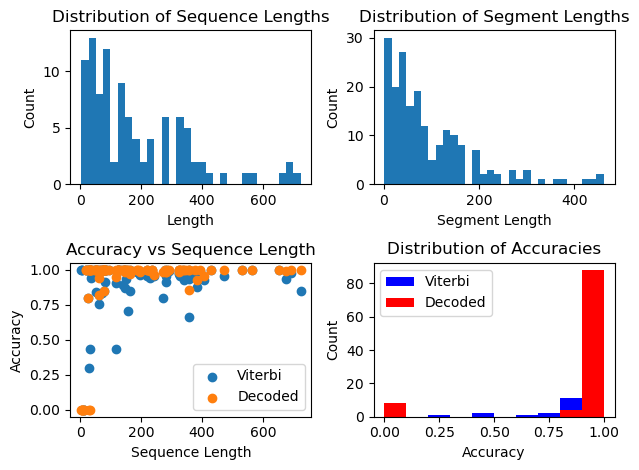

In [130]:
# 1) sequence lengths distribution
plt.subplot(2, 2, 1)
plt.hist(results['lengths'], bins=30)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Length')
plt.ylabel('Count')

# 2) segment lengths distribution
plt.subplot(2, 2, 2)
plt.hist(results['segment_lengths'], bins=30)
plt.title('Distribution of Segment Lengths')
plt.xlabel('Segment Length')
plt.ylabel('Count')

# 3) comparing accuracy and sequence length
plt.subplot(2, 2, 3)
plt.scatter(results['lengths'], results['viterbi_accuracies'], label='Viterbi')
plt.scatter(results['lengths'], results['decoded_accuracies'], label='Decoded')
plt.title('Accuracy vs Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.legend()

# 4) distribution of accuracy
plt.subplot(2, 2, 4)
plt.hist(results['viterbi_accuracies'], label='Viterbi', color='blue')
plt.hist(results['decoded_accuracies'], label='Decoded', color='red')
plt.title('Distribution of Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()


In [98]:
print(f"Average sequence length: {np.mean(results['lengths']):.1f} (should be 200)")
print(f"Average first segment length: {np.mean(results['segment_lengths']):.1f} (should be ~100)")
print(f"Average Viterbi accuracy: {np.mean(results['viterbi_accuracies']):.3f}")
print(f"Average decoded accuracy: {np.mean(results['decoded_accuracies']):.3f}")

Average sequence length: 183.5 (should be 200)
Average first segment length: 94.6 (should be ~100)
Average Viterbi accuracy: 0.913
Average decoded accuracy: 0.909


Looking at the accuracy trends in the generated sequences, both Viterbi and decoded accuracies tend to improve with longer sequence lengths, with sequences over 200bp almost consistently achieving accuracies above 0.9. There's more variability in accuracy for shorter sequences (less than 200bp), suggesting that longer sequences provide more context for accurate state prediction. The decoded accuracies seem slightly more stable than Viterbi, especially for shorter sequences, which makes sense because posterior decoding considers the ensemble of all possible paths whereas Viterbi finds the single most likely path through the states, making "all-or-nothing" decisions at each position.

If we compare the generated sequences to Moriarty's actual reads, there are several discrepancies. First, while Moriarty's reads are all exactly 200bp in length, our HMM generates sequences with widely varying lengths (averaging 184 bp) and ranging from very short (<100bp) to very long (>600bp). This is due to our use of geometric distributions for state transitions, which don't enforce a fixed length constraint. 

Most importantly, while Moriarty's reads are described as having exactly one transition point between the two phage segments, our HMM model doesn't enforce this constraint. Our model can generate sequences with multiple transitions between states or sometimes no transitions at all, which doesn't match the binary chimeric nature of the actual reads. Also, while our average first segment length (94.6 bp) is close to the target of 100bp, the distribution of segment lengths shows a geometric decay rather than clustering tightly around 100bp as we would expect in Moriarty's reads. 


## 3. Analyze Moriarty's read sequences

### 3.1 parse files

In [51]:
def read_fasta(filename):
    """
    Parameters:
        filename: path to FASTA file
    
    Returns:
        list of (name, sequence) tuples
    """
    seqs = []
    with open(filename) as f:
        name = None
        seq = []
        for line in f:
            if line.startswith('>'):
                if name:
                    seqs.append((name, ''.join(seq)))
                name = line[1:].strip()
                seq = []
            else:
                seq.append(line.strip())
        if name:
            seqs.append((name, ''.join(seq)))
    return seqs

def seq_to_idx(seq):
    """
    Parameters:
        seq: DNA sequence string
    
    Returns:
        array of indices (A=0,C=1,G=2,T=3)
    """
    return np.array([{'A':0,'C':1,'G':2,'T':3}[x] for x in seq.upper()])
    
def read_truth(filename):
    """
    Parameters:
        filename: path to truth file
    
    Returns:
        list of (L, k, g0, g1) tuples where:
            L = sequence length
            k = breakpoint position
            g0 = first genome (1=AluminumJesus, 2=T4)
            g1 = second genome
    """
    truth = []
    with open(filename) as f:
        for line in f:
            if not line.startswith('#'):
                fields = line.strip().split()
                if len(fields) == 5:
                    truth.append((int(fields[1]), int(fields[2]), 
                                int(fields[3]), int(fields[4])))
    return truth


In [53]:
def truth_to_path(L, k, g0, g1):
    """
    Parameters:
        L: sequence length
        k: breakpoint position
        g0: first genome (1=AluminumJesus, 2=T4)
        g1: second genome
    
    Returns:
        array of state indices matching the ground truth path
    """
    path = np.zeros(L, dtype=int)
    path[:k-1] = g0
    path[k-1:] = g1
    return path
    

### 3.2 analyze Moriarty's chimeric reads

In [59]:
def moriarty_reads():
    """
    Returns:
        list of dictionaries, one per sequence, containing:
            true_k: true breakpoint position
            vit_k: Viterbi-predicted breakpoint
            post_k: posterior-decoded breakpoint
            vit_acc: Viterbi path accuracy
            post_acc: posterior path accuracy
            true_path: ground truth state path
            vit_path: Viterbi state path
            post_path: posterior decoded path
    """
    seqs = read_fasta('moriarty-reads.fa')        # list of (name, sequence) tuples
    truth = read_truth('moriarty-reads.truth')    # list of (L, k, g0, g1) tuples
    t, e = make_hmm()                            # get transition and emission matrices
    
    # convert DNA sequences to numeric indices (A = 0,C = 1,G = 2,T = 3)
    # x[i] is the observed sequence i as an array of indices
    x = [seq_to_idx(seq) for name,seq in seqs]
    
    # convert truth data to state paths
    # true_paths[i] is array of states (1=AluminumJesus, 2=T4) for sequence i
    true_paths = [truth_to_path(L,k,g0,g1) for L,k,g0,g1 in truth]
    
    results = []
    for i in range(len(x)):
        # find optimal state path using Viterbi algorithm
        # vit_path = state sequence, vit_logp = log P(x,π|θ)
        vit_path, vit_logp = viterbi(x[i], t, e)
        
        # compute forward matrix and sequence probability
        # F = forward matrix, logp = log P(x|θ)
        F, logp = forward(x[i], t, e)
        
        # compute backward matrix
        # B = backward matrix, also gives log P(x|θ)
        B, _ = backward(x[i], t, e)
        
        # get posterior decoded path
        # post_path = state sequence from posterior decoding
        # D = posterior probability matrix P(πi=k|x,θ)
        post_path, D = posterior_decode(F, B, logp)
        
        # compare predicted paths to ground truth
        vit_acc, _ = compare_paths(true_paths[i], vit_path)
        post_acc, _ = compare_paths(true_paths[i], post_path)
        true_k = truth[i][1]  # true breakpoint from truth data
        
        # find Viterbi breakpoint (position of first state change)
        # np.diff finds differences between adjacent states
        # np.where finds positions where difference is non-zero
        vit_changes = np.where(np.diff(vit_path) != 0)[0]
        vit_k = vit_changes[0] + 1 if len(vit_changes) > 0 else None
        
        # find posterior decoded breakpoint
        post_changes = np.where(np.diff(post_path) != 0)[0]
        post_k = post_changes[0] + 1 if len(post_changes) > 0 else None
        
        # store results 
        results.append({
            'true_k': true_k,      
            'vit_k': vit_k,        
            'post_k': post_k,      
            'vit_acc': vit_acc,    
            'post_acc': post_acc,  
            'true_path': true_paths[i],  
            'vit_path': vit_path,        
            'post_path': post_path       
        })
    
    return results
    

### 3.3 visualizations

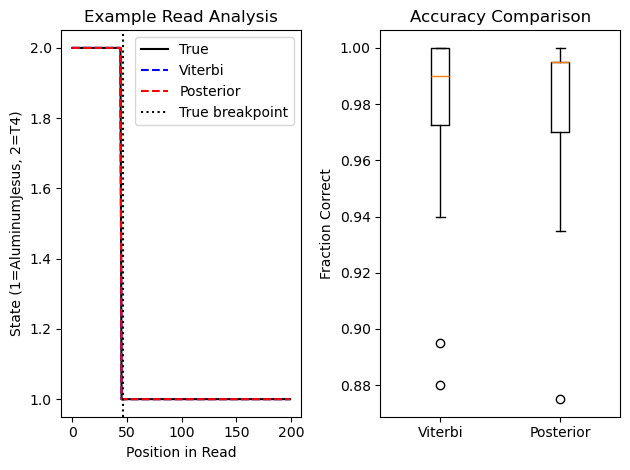

Average accuracy: Viterbi = 0.975, Posterior = 0.978


In [61]:
results = moriarty_reads() 

# 1) example reads
plt.subplot(1, 2, 1)
example_idx = 0  # first read
x = range(len(results[example_idx]['true_path']))
plt.plot(x, results[example_idx]['true_path'], 'k-', label='True')
plt.plot(x, results[example_idx]['vit_path'], 'b--', label='Viterbi')
plt.plot(x, results[example_idx]['post_path'], 'r--', label='Posterior')
plt.axvline(x=results[example_idx]['true_k'], color='k', linestyle=':', label='True breakpoint')
plt.title('Example Read Analysis')
plt.xlabel('Position in Read')
plt.ylabel('State (1 = AluminumJesus, 2 = T4)')
plt.legend()

# 2) accuracy comparison
plt.subplot(1, 2, 2)
vit_acc = [r['vit_acc'] for r in results]
post_acc = [r['post_acc'] for r in results]
plt.boxplot([vit_acc, post_acc], labels=['Viterbi', 'Posterior'])
plt.title('Accuracy Comparison')
plt.ylabel('Fraction Correct')

plt.tight_layout()
plt.show()
print(f"Average accuracy: Viterbi = {np.mean(vit_acc):.3f}, Posterior = {np.mean(post_acc):.3f}")


The HMM is highly accurate at identifying which residues came from which source genome. The example read (left plot) shows nearly perfect state identification, with both methods correctly identifying the sharp transition from state 2 (T4) to state 1 (AluminumJesus) at the true breakpoint. The overall accuracy (right plot) shows that both methods achieve >97% accuracy in identifying the correct source genome at each position. The median accuracy for both methods is around 98-99%, with relatively small spread in the box plots

Comparing the two algorithms, posterior decoding performs slightly better than Viterbi, but the difference is small with an average accuracy of Posterior (0.978) vs. Viterbi (0.975). Both methods have a few outlier cases (dots) where performance is lower

## 4. A better HMM/ approach...

### 4.1 better HMM for Moriarty's data

In [63]:
def better_hmm(L=200):
    """
    Parameters:
        L: sequence length 
    Returns:
        t: List of L transition matrices, one per position
        e: Emission probability matrix
    """
    # same emission probs
    e = np.array([[1/4, 1/4, 1/4, 1/4],        # state 0 (unused)
                  [0.166, 0.334, 0.334, 0.166], # state 1 (AluminumJesus)
                  [0.323, 0.177, 0.177, 0.323]] # state 2 (T4)
    )
    
    # create L position-specific transition matrices
    t = []
    for pos in range(L):
        # at each position, we need a 3x3 matrix (states 0,1,2)
        t_pos = np.zeros((3, 3))
        
        if pos == 0:  # start- must go to T4 (state 2)
            t_pos[0,2] = 1.0
        elif pos == L-1:  # end- must be in AluminumJesus (state 1)
            t_pos[1,0] = 1.0
            t_pos[2,1] = 1.0
        else:  # middle positions
            # T4 can either stay T4 or transition to AluminumJesus
            t_pos[2,2] = 0.95  # stay in T4
            t_pos[2,1] = 0.05  # switch to AluminumJesus
            t_pos[1,1] = 1.0   # once in AluminumJesus, must stay there
            
        t.append(t_pos)
    
    return t, e


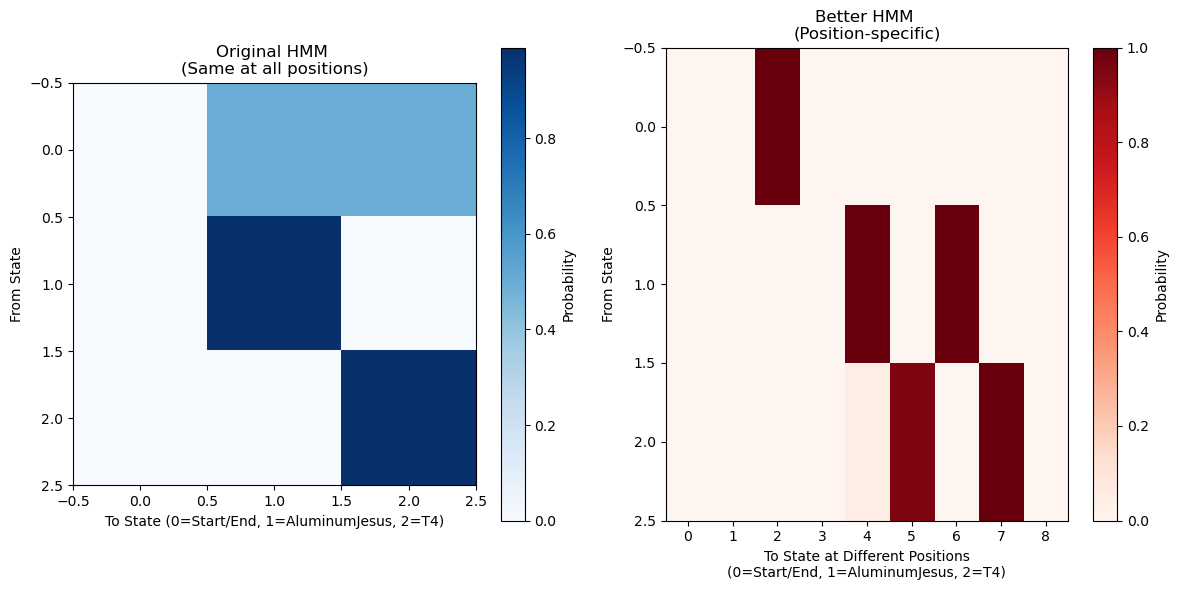

In [116]:
t_orig, e_orig = make_hmm()
t_better, e_better = better_hmm()

# 1) original HMM transitions (constant across positions)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(t_orig, cmap='Blues', aspect='equal')
plt.colorbar(label='Probability')
plt.title('Original HMM \n(Same at all positions)')
plt.xlabel('To State (0=Start/End, 1=AluminumJesus, 2=T4)')
plt.ylabel('From State')


# 2) better HMM transitions (show three key positions)
plt.subplot(1, 2, 2)
# stack transitions from three important positions
key_positions = [0, 100, 199]  # start, middle, end
labels = ['Start', 'Middle', 'End']
# matrix showing these three positions side by side
comparison = np.hstack([t_better[pos] for pos in key_positions])
plt.imshow(comparison, cmap='Reds', aspect='auto')
plt.colorbar(label='Probability')
plt.title('Better HMM \n(Position-specific)')
plt.xlabel('To State at Different Positions\n(0=Start/End, 1=AluminumJesus, 2=T4)')
plt.ylabel('From State')

plt.tight_layout()
plt.show()


In our original HMM:
- Variable sequence length
- Same transitions at all positions
- Equal probability (0.5)of starting in either state
- States can transition back and forth multiple times

We can make a better HMM for Moriarity's reads by having: 
- Fixed sequence length of 200bp
- Position-specific transitions that enforce:
  - Start: must begin in T4 (state 2)
  - Middle: only allows T4→AluminumJesus transition (no going back)
  - End: must end in AluminumJesus (state 1)
- One transition from T4 to AluminumJesus
- Always ends in AluminumJesus

### 4.2 probability model- better fit for Moriarty's data!

In [65]:
def simpler_model(seq, k):
    """
    Non-HMM model that directly models one transition at position k
    
    Parameters:
        seq: array of base indices (0-3 for A,C,G,T)
        k: breakpoint position
    Returns:
        log_prob: log probability of sequence given breakpoint k
    """
    # emission prob for each state
    t4_emit = np.array([0.323, 0.177, 0.177, 0.323])  # T4
    aj_emit = np.array([0.166, 0.334, 0.334, 0.166])  # AluminumJesus
    
    log_prob = 0
    for i in range(k):  # first segment (T4)
        log_prob += np.log(t4_emit[seq[i]])
    for i in range(k, len(seq)): # second segment (AluminumJesus)
        log_prob += np.log(aj_emit[seq[i]])
    
    return log_prob

def find_best_breakpoint(seq):
    """
    Parameters: seq: array of base indices (0-3 for A,C,G,T)
    Returns:
        best_k: most likely breakpoint position
        log_prob: log probability of best breakpoint
    """
    L = len(seq)
    best_k = None
    best_log_prob = -np.inf
    
    # try every possible breakpoint
    for k in range(1, L):
        log_prob = simpler_model(seq, k)
        if log_prob > best_log_prob:
            best_log_prob = log_prob
            best_k = k
            
    return best_k, best_log_prob


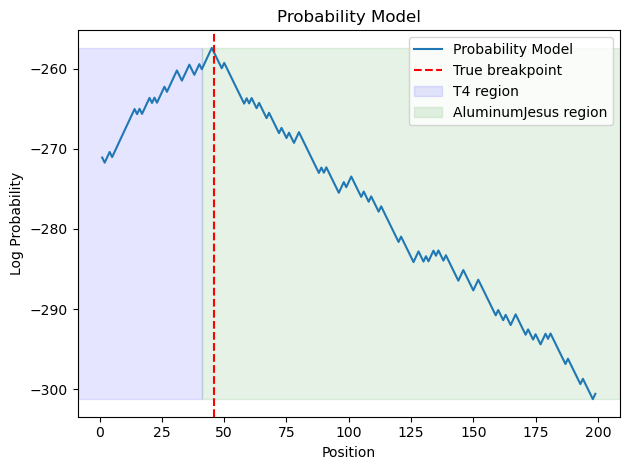

In [120]:
def read_fasta(filename):
    seqs = []
    current_seq = []
    
    with open(filename) as f:
        for line in f:
            if line.startswith('>'):
                if current_seq:
                    seqs.append(''.join(current_seq))
                current_seq = []
            else:
                current_seq.append(line.strip())
        if current_seq:
            seqs.append(''.join(current_seq))
            
    return seqs

def seq_to_idx(seq):
    base_to_idx = {'A':0, 'C':1, 'G':2, 'T':3}
    return np.array([base_to_idx[x] for x in seq.upper()])

seqs = read_fasta('moriarty-reads.fa')
truth = read_truth('moriarty-reads.truth')

# process first sequence as example
seq = seq_to_idx(seqs[0])
true_k = truth[0][1]

# compute log probabilities for all possible breakpoints
L = len(seq)
ks = range(1, L)
log_probs = [simpler_model(seq, k) for k in ks]

plt.plot(ks, log_probs, label='Probability Model')
plt.axvline(x=true_k, color='r', linestyle='--', label='True breakpoint')
# use color to show genome sources
plt.axhspan(ymin=min(log_probs), ymax=max(log_probs), 
            xmin=0, xmax=true_k/L,
            color='blue', alpha=0.1, label='T4 region')
plt.axhspan(ymin=min(log_probs), ymax=max(log_probs), 
            xmin=true_k/L, xmax=1,
            color='green', alpha=0.1, label='AluminumJesus region')

plt.xlabel('Position')
plt.ylabel('Log Probability')
plt.title('Probability Model')
plt.legend()
plt.tight_layout()
plt.show()

This simple probability model is best for Moriarity's data because it just need to pick a single breakpoint k (similar to picking a motif start position) then directly calculate P(sequence|k) using first k positions (T4 composition) and remaining positions (AluminumJesus composition). Because we already know the fixed length of the sequence and that there is only one transition, the model can find what we want to find with fewer parameters (k) whereas HMM is a much more complex state machine with multiple transitions and parameters. 


In [122]:
# watermark 
import watermark 
%load_ext watermark 
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyterlab

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.25.0

numpy     : 1.26.4
matplotlib: 3.8.4
seaborn   : 0.13.2
pandas    : 2.2.2
jupyterlab: 4.0.11

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

